<a href="https://colab.research.google.com/github/Sergei-N-Fedorov/Data_Analysis/blob/main/EMLM_Exercise2_Sergei_Fedorov_(sefedo).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2026
## deadline: 11.2.2026 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: **Sergei Fedorov**

Student number: **2511405**

Student email: sefedo@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=9 (9NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 9-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points):

- input.csv, contains the 75 predictor features.
- output.csv, contains the water permebility values.
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points.

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv).

#### 2. Perform spatial leave-one-out cross-validation with 9NN model for the provided data set (refer to the video lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 9NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m).

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following:

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 9-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.

- Plot of the graph C-index vs. distance parameter value.

### Other guidelines on the return:

- Return your solution as a Jupyter Notebook (.ipynb) and as a PDF file generated from it. Please, add your full name to the file name.
- Make sure that the code is runnable as is.
- If AI was used, please explain at the end of the notebook, in the "AI usage disclaimer" section, how and in which parts it was applied.
- The exercise will be graded as pass/fail.
- Submit to moodle your solution on **Wednesday 11th of February** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br>
Submissions with identical or similar code will result in a failure for the exercise.</b>


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [1]:
# In this cell, import all the libraries that you need. For example:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, LeaveOneOut

### Read in the datasets

In [2]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).
X = pd.read_csv('input.csv', header = None)
y = pd.read_csv('output.csv', header = None)
coord = pd.read_csv('coordinates.csv', header = None)

print("Data dimensions (rows x columns)")
print("   Input:", X.shape)
print("   Output:", y.shape)
print("   Coordinates:", coord.shape)

Data dimensions (rows x columns)
   Input: (1691, 75)
   Output: (1691, 1)
   Coordinates: (1691, 2)


In [3]:
# Input data example
display(X.head().style.format("{:.2f}"))
print("\nDescriptive statistics")
display(X.describe().drop(index = 'count').style.format("{:.4f}"))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,-0.05,-0.22,0.21,0.70,0.34,0.41,0.33,-0.03,-0.18,0.31,0.40,0.24,-0.95,-0.27,-0.06,-0.54,-0.19,-0.10,0.12,0.15,-0.08,-0.06,-0.58,0.29,0.99,5.09,-0.33,-0.39,1.56,-1.03,-1.18,-0.01,1.47,-0.52,0.31,2.76,-0.40,-0.49,-0.51,-0.41,-0.58,-0.93,-0.48,-0.40,0.53,0.36,0.28,1.33,0.24,-0.32,-0.59,2.32,1.07,0.27,-1.01,1.01,-0.56,-0.53,-0.44,-0.40,-0.70,1.66,0.16,-0.72,0.33,0.22,0.54,-0.65,-0.52,-0.45,0.55,0.09,-0.11,-0.91,-0.46
1,-0.63,-0.68,-0.29,-0.37,-0.14,2.49,2.05,-0.03,-0.25,-0.23,0.23,0.40,2.29,-0.36,-0.65,-0.54,-0.19,-0.10,0.12,0.05,-0.51,-0.51,0.66,0.21,0.10,-0.34,-0.33,-0.39,1.56,-1.03,0.97,0.48,-0.45,-0.52,-0.61,0.12,-0.40,-0.49,-0.51,-1.02,1.11,0.49,0.74,-0.40,-0.43,-1.23,-1.22,-0.34,-0.69,-0.61,-0.59,-0.42,-0.42,-0.76,0.25,-0.15,-1.14,3.40,1.95,-0.40,-0.70,-0.39,-0.69,-0.72,0.33,0.22,-0.17,-0.65,2.48,-0.45,-0.29,-0.04,-1.48,-1.09,-0.46
2,-0.67,-0.60,-0.57,-0.98,-0.83,-0.50,-0.45,-0.03,-0.32,-0.63,-0.45,-0.74,0.57,-0.35,-0.53,-0.54,-0.19,-0.10,-0.75,-1.00,-1.48,-1.42,1.19,0.61,-1.02,-0.34,-0.33,-0.39,-0.42,-1.03,-0.32,1.47,1.47,-0.52,-0.15,-0.54,-0.40,-0.49,-0.51,-1.02,-0.16,0.49,3.20,1.13,0.05,0.17,-0.34,1.56,3.80,1.15,-0.59,-0.42,2.56,-0.76,1.51,-0.15,-1.14,-0.53,-0.44,-0.40,-0.70,-0.39,1.00,1.59,1.68,-1.05,-0.88,-0.65,-0.52,-0.45,-0.38,-0.16,0.35,0.13,-0.81
3,-0.33,-0.15,1.31,0.09,0.42,1.06,0.96,-0.03,-0.30,-0.36,-0.62,-0.17,-0.19,-0.27,-0.18,0.06,-0.19,-0.10,-0.10,-0.19,-1.48,-1.42,1.19,0.61,-1.02,-0.34,-0.33,-0.39,-0.42,-1.03,-0.32,1.47,1.47,-0.52,-0.15,-0.54,-0.40,-0.49,-0.51,-1.02,-0.16,0.49,3.20,1.13,0.05,0.17,-0.34,1.56,3.80,1.15,-0.59,-0.42,2.56,-0.76,1.51,-0.15,-1.14,-0.53,-0.44,-0.40,-0.70,-0.39,1.00,1.59,1.68,-1.05,-0.88,-0.65,-0.52,-0.45,-0.38,0.70,0.47,0.11,-0.83
4,-0.61,-0.67,-0.16,-0.52,-0.38,0.67,0.80,-0.03,-0.36,-0.96,-0.45,-0.34,0.38,-0.36,-0.65,-0.54,-0.19,-0.10,-0.53,-0.93,-1.16,-1.13,0.84,0.93,0.35,-0.34,-0.33,-0.39,-0.42,0.17,0.11,0.97,-0.45,-0.52,-0.61,-0.54,-0.40,-0.49,-0.51,-0.41,1.11,-0.22,1.97,-0.40,-0.43,-1.22,-1.12,0.07,1.41,0.73,1.56,-0.42,-0.42,-0.76,-0.38,-0.15,-0.56,0.78,1.95,2.47,0.30,-0.39,-0.69,-0.72,-0.34,-1.05,-0.88,2.10,0.98,1.96,-0.30,0.09,-0.33,-0.64,-0.54



Descriptive statistics


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
mean,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000
std,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003
min,-0.8572,-0.8328,-1.8606,-2.2106,-2.4741,-1.4048,-1.2332,-0.0344,-0.4108,-1.1615,-0.7961,-2.1269,-1.3361,-0.3862,-0.8207,-0.5377,-0.1898,-0.0970,-2.0514,-1.7805,-1.9153,-1.9151,-1.1073,-1.7024,-1.5751,-0.3395,-0.3310,-0.3868,-0.4151,-1.0253,-1.1773,-0.9913,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-1.0209,-1.0049,-0.9324,-0.4847,-0.3989,-0.4340,-1.8737,-1.7120,-0.9209,-1.2198,-1.1180,-0.5865,-0.4224,-0.4195,-0.7587,-1.0083,-1.9001,-1.1368,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-1.0188,-1.0477,-0.8776,-0.6453,-0.5199,-0.4471,-1.9595,-10.1387,-2.1026,-1.2680,-2.8524
25%,-0.8572,-0.8328,-0.7988,-0.5230,-0.5365,-0.6259,-0.9203,-0.0344,-0.3249,-0.6274,-0.7961,-0.6609,-0.7629,-0.3862,-0.8207,-0.5377,-0.1898,-0.0970,-0.7474,-0.9011,-0.4978,-0.4898,-0.5763,-0.7457,-0.7012,-0.3395,-0.3310,-0.3868,-0.4151,-1.0253,-0.7471,-0.9913,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-1.0209,-1.0049,-0.9324,-0.4847,-0.3989,-0.4340,-0.9939,-0.9702,-0.7615,-0.6291,-0.6822,-0.5865,-0.4224,-0.4195,-0.7587,-1.0083,-0.7345,-1.1368,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-1.0188,-0.4141,-0.8776,-0.6453,-0.5199,-0.4471,-0.7123,-0.1591,-0.6885,-0.7354,-0.5239
50%,-0.5035,-0.5596,-0.2147,-0.0627,0.0475,-0.2365,-0.1382,-0.0344,-0.2859,-0.3603,-0.4534,0.1536,-0.1897,-0.3377,-0.5880,-0.5377,-0.1898,-0.0970,0.1220,0.1136,-0.1434,-0.1513,-0.3993,-0.2292,-0.2100,-0.3395,-0.3310,-0.3868,-0.4151,-0.4262,-0.3170,-0.5000,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-0.4098,-0.1604,-0.2228,-0.4847,-0.3989,-0.4340,0.2857,0.3361,-0.3525,-0.2870,-0.3211,-0.5865,-0.4224,-0.4195,-0.7587,-0.3787,-0.1517,0.0219,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-0.3432,-0.4141,-0.1693,-0.6453,-0.5199,-0.4471,-0.3737,0.0873,0.0542,-0.2008,-0.0863
75%,0.6436,0.7419,0.8118,0.7044,0.7376,0.4126,0.6439,-0.0344,-0.0908,0.7080,0.5746,0.6423,0.5745,-0.0873,0.7500,0.0597,-0.1898,-0.0970,0.7740,0.6548,0.5654,0.5613,0.4858,0.4445,0.3695,-0.3395,-0.3310,-0.3868,-0.4151,0.7719,0.5432,0.4825,-0.4503,-0.5208,0.3057,0.1227,-0.4042,-0.4875,0.6323,0.8123,0.6841,0.4867,-0.4847,-0.3989,-0.4340,0.7470,0.7317,0.4186,0.4296,0.4880,1.5649,-0.4224,-0.4195,1.2990,0.8805,0.4310,0.6012,0.7809,-0.4431,-0.4047,0.2983,-0.3865,1.0030,0.0515,0.3324,0.2195,0.5391,0.2693,0.2289,-0.4471,0.3968,0.3337,0.5651,0.5268,0.2827
max,3.1415,3.3631,1.8736,2.3921,1.9055,3.3985,3.3032,29.0603,5.7382,4.9811,5.0296,2.8413,5.5421,6.6822,2.7861,7.0293,12.8778,10.4826,1.8606,2.3797,6.8435,6.8325,6.8585,6.2027,7.5564,6.9046,3.0209,6.8013,7.4944,2.5696,2.6942,3.4304,7.2418,5.5672,3.5092,3.4170,5.1532,5.8711,5.2024,3.8683,2.7957,5.4543,5.6603,8.8006,3.9203,1.6321,1.6080,5.9

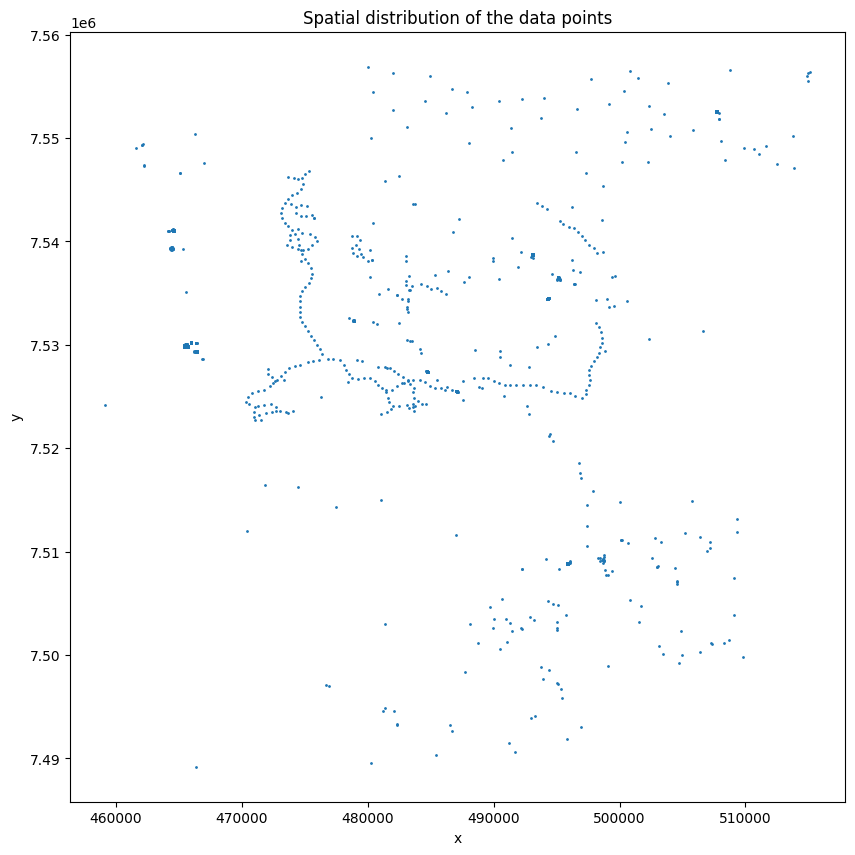

In [4]:
# Visualizing spatial distribution
plt.figure(figsize = (10, 10))
plt.scatter(coord.iloc[:, 0], coord.iloc[:, 1], s = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Spatial distribution of the data points')
plt.show()

### Standardization of the predictor features (input.csv)

**Note**: The input data look already scaled pretty well (see the table above). The standard deviation values are slightly larger than 1 but still they are all equal.

Another observation is that, as far as I know, scaling should be executed each time after splitting the data into folds, so that the scaler is fitted on the training set only and then all the input data are transformed by it.

However, let's scale the data as required in the exercise.

In [5]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance.
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled)
display(X_scaled_df.describe().drop(index = 'count').style.format("{:.4f}"))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
mean,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000
std,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003,1.0003
min,-0.8572,-0.8328,-1.8606,-2.2106,-2.4741,-1.4048,-1.2332,-0.0344,-0.4108,-1.1615,-0.7961,-2.1269,-1.3361,-0.3862,-0.8207,-0.5377,-0.1898,-0.0970,-2.0514,-1.7805,-1.9153,-1.9151,-1.1073,-1.7024,-1.5751,-0.3395,-0.3310,-0.3868,-0.4151,-1.0253,-1.1773,-0.9913,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-1.0209,-1.0049,-0.9324,-0.4847,-0.3989,-0.4340,-1.8737,-1.7120,-0.9209,-1.2198,-1.1180,-0.5865,-0.4224,-0.4195,-0.7587,-1.0083,-1.9001,-1.1368,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-1.0188,-1.0477,-0.8776,-0.6453,-0.5199,-0.4471,-1.9595,-10.1387,-2.1026,-1.2680,-2.8524
25%,-0.8572,-0.8328,-0.7988,-0.5230,-0.5365,-0.6259,-0.9203,-0.0344,-0.3249,-0.6274,-0.7961,-0.6609,-0.7629,-0.3862,-0.8207,-0.5377,-0.1898,-0.0970,-0.7474,-0.9011,-0.4978,-0.4898,-0.5763,-0.7457,-0.7012,-0.3395,-0.3310,-0.3868,-0.4151,-1.0253,-0.7471,-0.9913,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-1.0209,-1.0049,-0.9324,-0.4847,-0.3989,-0.4340,-0.9939,-0.9702,-0.7615,-0.6291,-0.6822,-0.5865,-0.4224,-0.4195,-0.7587,-1.0083,-0.7345,-1.1368,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-1.0188,-0.4141,-0.8776,-0.6453,-0.5199,-0.4471,-0.7123,-0.1591,-0.6885,-0.7354,-0.5239
50%,-0.5035,-0.5596,-0.2147,-0.0627,0.0475,-0.2365,-0.1382,-0.0344,-0.2859,-0.3603,-0.4534,0.1536,-0.1897,-0.3377,-0.5880,-0.5377,-0.1898,-0.0970,0.1220,0.1136,-0.1434,-0.1513,-0.3993,-0.2292,-0.2100,-0.3395,-0.3310,-0.3868,-0.4151,-0.4262,-0.3170,-0.5000,-0.4503,-0.5208,-0.6094,-0.5361,-0.4042,-0.4875,-0.5100,-0.4098,-0.1604,-0.2228,-0.4847,-0.3989,-0.4340,0.2857,0.3361,-0.3525,-0.2870,-0.3211,-0.5865,-0.4224,-0.4195,-0.7587,-0.3787,-0.1517,0.0219,-0.5304,-0.4431,-0.4047,-0.7045,-0.3865,-0.6905,-0.7193,-0.3432,-0.4141,-0.1693,-0.6453,-0.5199,-0.4471,-0.3737,0.0873,0.0542,-0.2008,-0.0863
75%,0.6436,0.7419,0.8118,0.7044,0.7376,0.4126,0.6439,-0.0344,-0.0908,0.7080,0.5746,0.6423,0.5745,-0.0873,0.7500,0.0597,-0.1898,-0.0970,0.7740,0.6548,0.5654,0.5613,0.4858,0.4445,0.3695,-0.3395,-0.3310,-0.3868,-0.4151,0.7719,0.5432,0.4825,-0.4503,-0.5208,0.3057,0.1227,-0.4042,-0.4875,0.6323,0.8123,0.6841,0.4867,-0.4847,-0.3989,-0.4340,0.7470,0.7317,0.4186,0.4296,0.4880,1.5649,-0.4224,-0.4195,1.2990,0.8805,0.4310,0.6012,0.7809,-0.4431,-0.4047,0.2983,-0.3865,1.0030,0.0515,0.3324,0.2195,0.5391,0.2693,0.2289,-0.4471,0.3968,0.3337,0.5651,0.5268,0.2827
max,3.1415,3.3631,1.8736,2.3921,1.9055,3.3985,3.3032,29.0603,5.7382,4.9811,5.0296,2.8413,5.5421,6.6822,2.7861,7.0293,12.8778,10.4826,1.8606,2.3797,6.8435,6.8325,6.8585,6.2027,7.5564,6.9046,3.0209,6.8013,7.4944,2.5696,2.6942,3.4304,7.2418,5.5672,3.5092,3.4170,5.1532,5.8711,5.2024,3.8683,2.7957,5.4543,5.6603,8.8006,3.9203,1.6321,1.6080,5

### Functions and analysis code

In [6]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt):
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt):
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

### Results for spatial leave-one-out cross-validation with 9-nearest neighbor regression model

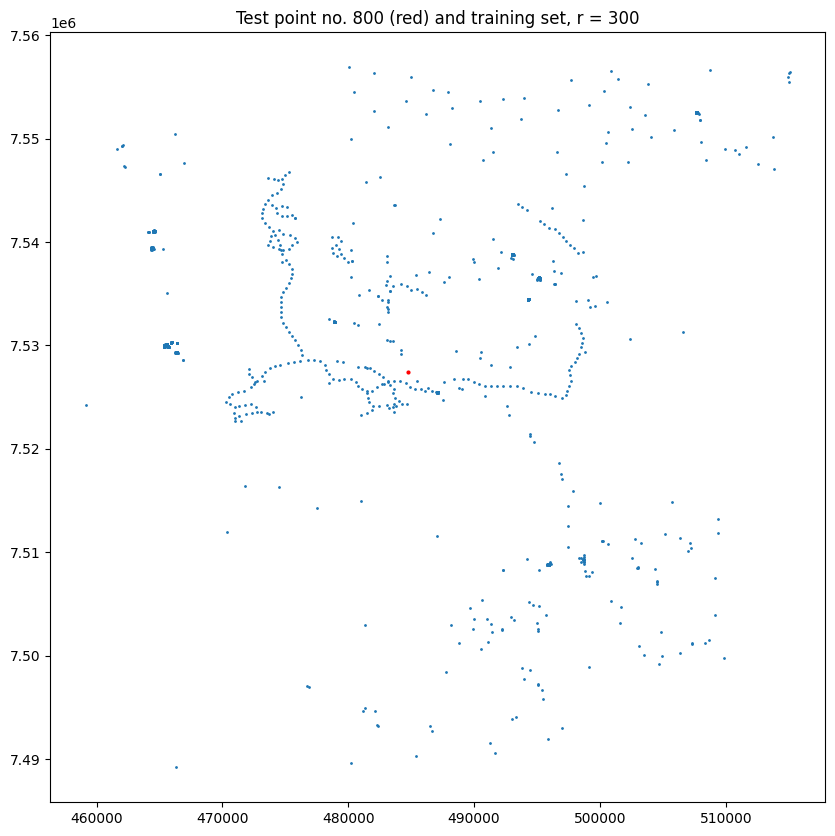

In [7]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation
# with 9-nearest neighbor regression model and visualize the results as
# requested in the task assignment.

c_r = []  # 2-dim. array with C-index values for different distance parameters r
distances = cdists(coord.to_numpy()) # distance matrix for the datapoints
y_true = y.astype(float).to_numpy()

# Implementing spatial LOOCV for each distance parameter value
for r in range(0, 301, 20):
  loo = LeaveOneOut()
  y_pred = np.zeros(len(y_true))

  for train_index, test_index in loo.split(X_scaled):
    train_idx_far = []
    for idx in train_index:
      if distances[idx, test_index[0]] > r:     # only use points further than r
        train_idx_far.append(idx)               # from the test point
    X_train, X_test = X_scaled[train_idx_far], X_scaled[test_index]
    y_train, y_test = y_true[train_idx_far], y_true[test_index]

    if (r == 300) & (test_index[0] == 800):     # check SKCV visually for one case
      plt.figure(figsize = (10, 10))
      plt.scatter(coord.iloc[train_idx_far, 0], coord.iloc[train_idx_far, 1], s = 1)
      plt.scatter(coord.iloc[test_index[0], 0], coord.iloc[test_index[0], 1], s = 4, c = 'red')
      plt.title('Test point no. 800 (red) and training set, r = 300')
      plt.show()

    model = KNeighborsRegressor(n_neighbors = 9)    # fit the model
    model.fit(X_train, y_train)
    y_pred[test_index] = model.predict(X_test)[0]   # and get its prediction for the test point

  c_r.append([cindex(y_true, y_pred), r])           # save C-index and corresponding r

In [8]:
print("  C-index             r")
c_r

  C-index             r


[[0.7185855537154449, 0],
 [0.7082643291816516, 20],
 [0.703137489868114, 40],
 [0.6950424804256862, 60],
 [0.6856312007492346, 80],
 [0.6813695090077542, 100],
 [0.6151787201695578, 120],
 [0.5936872225543132, 140],
 [0.5891647966133252, 160],
 [0.585546365890227, 180],
 [0.5833065016260015, 200],
 [0.5806106149967312, 220],
 [0.5800359498214408, 240],
 [0.5793646904997557, 260],
 [0.579103606321457, 280],
 [0.5784652450061526, 300]]

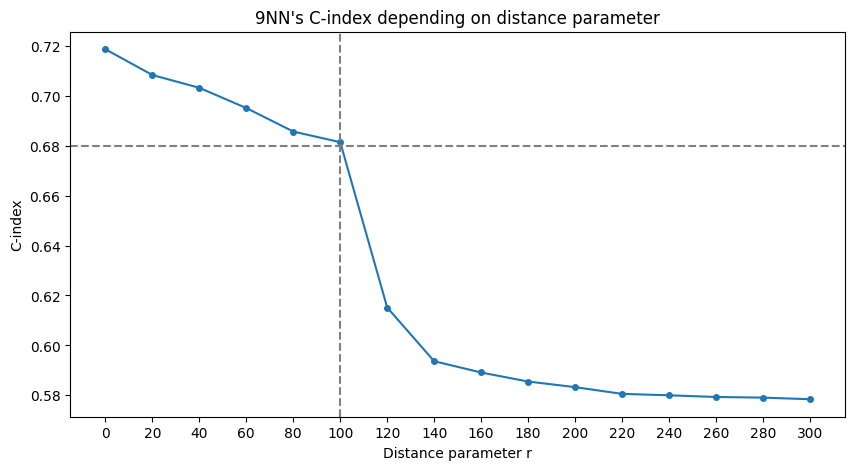

In [10]:
# Plotting the resulting C-indices for various distance parameters
c_r_np = np.array(c_r)

plt.figure(figsize = (10, 5))
plt.plot(c_r_np[:, 1], c_r_np[:, 0], linestyle='-', marker = 'o', markersize = 4)
plt.xticks(range(0, 301, 20))
plt.axhline(y=0.68, linestyle='--', color='gray')
plt.axvline(x=100, linestyle='--', color='gray')
plt.xlabel('Distance parameter r')
plt.ylabel('C-index')
plt.title("9NN's C-index depending on distance parameter")
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 9NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 9NN must have at least C-index performance of 0.68, then up to what distance should we trust the 9NN predictions, based on the results?

### Answers

  1. When the distance increases, the performance of the model decreases. Moreover, it has a steep drop after the distance value of 100 m and then decreases slowly.

  2. This decreasing itself is quite expectable because of spatial autocorrelation of datapoints: features of geographically close points tend to be interdependent while very distant pairs of points can be considered as mutualy independent. So, having in the training set points close to the test ones the model is able to predict better in general.
  I'm not sure, though, about the steep decline of performance between 100 and 140 m. Probably, it is determined by the specific physical properies of soil with respect to water permeability.

  3. From the plot, we can see that the C-index performance of 0.68 or higher is provided by 9NN model only when the distance parameter is 100 m or smaller. This means we can trust the model at the forementioned level when estimating water permeability for points that are at the distance up to 100 m from the points with known water permeability values.

## AI usage disclaimer



AI was used for explaining errors in the code and for getting hints about plot drawing.